# Model Evaluation

## Agenda

1. Null accuracy, handling missing values
2. Confusion matrix, sensitivity, specificity, setting a threshold
3. Handling categorical features, interpreting logistic regression coefficients
4. Cross-Validation

## Part 1: Null Accuracy, Handling Missing Values

For a description of the Titanic dataset see this Kaggle page: https://www.kaggle.com/c/titanic/data

In [1]:
# TASK 1: read the data from titanic.csv into a DataFrame
import pandas as pd
titanic = pd.read_csv('titanic.csv', index_col='PassengerId')

# TASK 2: define Pclass/Parch as the features and Survived as the response
feature_cols = ['Pclass', 'Parch']
X = titanic[feature_cols]
y = titanic.Survived

# TASK 3: split the data into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# TASK 4: fit a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# TASK 5: make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.668161434978


### Null accuracy

Null accuracy is the accuracy that could be achieved by always predicting the **most frequent class**. It is a baseline against which you may want to measure your classifier.

In [2]:
# compute null accuracy manually
print y_test.mean()
print 1 - y_test.mean()

0.42600896861
0.57399103139


In [3]:
# equivalent function in scikit-learn
# http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
from sklearn.dummy import DummyClassifier
dumb = DummyClassifier(strategy='most_frequent')
dumb.fit(X_train, y_train)
y_dumb_class = dumb.predict(X_test)
print metrics.accuracy_score(y_test, y_dumb_class)

0.57399103139


### Handling missing values

scikit-learn models expect that all values are **numeric** and **hold meaning**. Thus, missing values are not allowed by scikit-learn.

One possible strategy is to just **drop missing values**:

In [4]:
# check for missing values
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [5]:
# drop rows with any missing values
titanic.dropna().shape

(183, 11)

In [6]:
# drop rows where Age is missing
titanic[titanic.Age.notnull()].shape

(714, 11)

Sometimes a better strategy is to **impute missing values**:

In [7]:
# fill missing values for Age with the mean age
titanic.Age.fillna(titanic.Age.mean(), inplace=True)

In [8]:
# equivalent function in scikit-learn, supports mean/median/most_frequent
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean', axis=1)
titanic['Age'] = imp.fit_transform(titanic.Age.reshape(1,-1)).T

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [9]:
# include Age as a feature
feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]

# TASK : split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# TASK : fit a logistic regression model
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
# TASK : make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)
print metrics.accuracy_score(y_test, y_pred_class)

0.67264573991


## Part 2: Confusion Matrix

In [10]:
# confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[107,  21],
       [ 52,  43]])

For a plotting function that will plot a nice confusion matrix see: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [11]:
# %load confusion_matrix_nice.py
# from confusion_matrix_nice import plot_confusion_matrix
%run confusion_matrix_nice

Confusion matrix, without normalization
[[107  21]
 [ 52  43]]


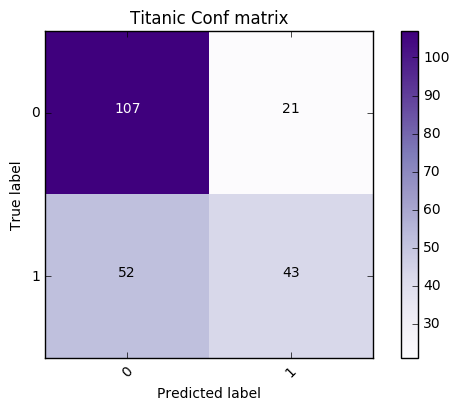

In [12]:
# plot an attractive confusion matrix
cnf_mat = metrics.confusion_matrix(y_test, y_pred_class, labels = titanic.Survived.unique())
class_labels = titanic.Survived.unique()
plt.figure()
plot_confusion_matrix(cnf_mat, class_labels,
                          normalize=False,
                          title='Titanic Conf matrix',
                          cmap=plt.cm.Purples)
plt.show()

In [13]:
# Establish cm values
TP = 43
FP = 52
TN = 107
FN = 21

In [14]:
# calculate the sensitivity
# TP / (TP+FP)
# 43 / float(52 + 43)
# display as %
#'{:.2%}'.format(TP/float(TP+FP))
# allocate sens
sens = '{:.2%}'.format(TP/float(TP+FP))

In [15]:
# calculate the specificity
# TN / (TN+FN)
#107 / float(107 + 21)
# display as %
#'{:.2%}'.format(TN/float(TN+FN))
#allocate spec
spec = '{:.2%}'.format(TN/float(TN+FN))

In [16]:
# store the predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

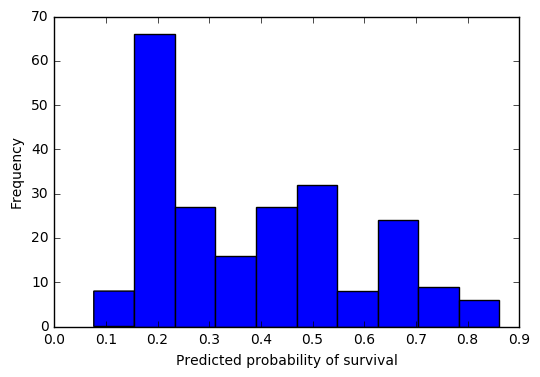

In [17]:
# plot the predicted probabilities
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(y_pred_prob)
plt.xlabel('Predicted probability of survival')
plt.ylabel('Frequency')

In [18]:
# change the threshold for predicting survived to increase sensitivity
import numpy as np
y_pred_class = np.where(y_pred_prob > 0.25, 1, 0)

In [19]:
# equivalent function in scikit-learn
from sklearn.preprocessing import binarize
y_pred_class = binarize(y_pred_prob.reshape(1,-1), 0.25).T

In [20]:
# new confusion matrix
print metrics.confusion_matrix(y_test, y_pred_class)

[[57 71]
 [27 68]]


Confusion matrix, without normalization
[[57 71]
 [27 68]]


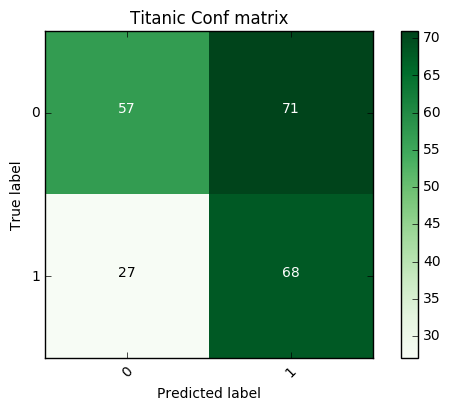

In [21]:
# make it look nice
cnf_mat = metrics.confusion_matrix(y_test, y_pred_class, labels = titanic.Survived.unique())
class_labels = titanic.Survived.unique()
plt.figure()
plot_confusion_matrix(cnf_mat, class_labels,
                          normalize=False,
                          title='Titanic Conf matrix',
                          cmap=plt.cm.Greens)
plt.show()

In [22]:
# Establish cm values
nTP = 68
nFP = 27
nTN = 57
nFN = 71

In [23]:
# new sensitivity
#print 68 / float(27 + 68)
# display as %
#'{:.2%}'.format(nTP/float(nTP+nFP))
# allocate nsens
nsens = '{:.2%}'.format(nTP/float(nTP+nFP))

In [24]:
# new specificity
#print 57 / float(57 + 71)
# display as %
#'{:.2%}'.format(nTN/float(nTN+nFN))
# allocate nspec
nspec = '{:.2%}'.format(nTN/float(nTN+nFN))

In [25]:
print ('Old Sensativity: ')
print sens
print ('New Sensativity: ')
print nsens
print ('Old Specificity: ')
print spec
print ('New Specificity: ')
print nspec

Old Sensativity: 
45.26%
New Sensativity: 
71.58%
Old Specificity: 
83.59%
New Specificity: 
44.53%


## Part 3: Handling Categorical Features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding

**Pclass** is an ordered categorical feature, and is already encoded as 1/2/3, so we leave it as-is.

**Sex** is an unordered categorical feature, and needs to be dummy encoded.

### Dummy encoding with two levels

In [26]:
# encode Sex_Female feature
titanic['Sex_Female'] = titanic.Sex.map({'male':0, 'female':1})

In [27]:
# include Sex_Female in the model
feature_cols = ['Pclass', 'Parch', 'Age', 'Sex_Female']
X = titanic[feature_cols]
# TASK : split the data into training and testing sets
X_train, X_test, y_train, y_test = ...
# TASK : fit a logistic regression model
logreg = ...

SyntaxError: invalid syntax (<ipython-input-27-9144083563c7>, line 5)

### Logistic regression coefficients

In [ ]:
zip(feature_cols, logreg.coef_[0])

$$\log \left({p\over 1-p}\right) = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_4$$

In [ ]:
# convert log-odds to odds
zip(feature_cols, np.exp(logreg.coef_[0]))

Predict probability of survival for **Adam**: first class, no parents or kids, 29 years old, male.

In [ ]:
adam = np.array([1, 0, 29, 0]).reshape(1,-1) # input observation needs to be 1 row of a 2d array
logreg.predict_proba(adam)[:, 1]

### Interpreting the Pclass coefficient

Predict probability of survival for **Bill**: same as Adam, except second class.

In [ ]:
bill = np.array([2, 0, 29, 0]).reshape(1,-1)
logreg.predict_proba(bill)[:, 1]

How could we have calculated that change ourselves using the coefficients?

$$odds = \frac {probability} {1 - probability}$$

$$probability = \frac {odds} {1 + odds}$$

In [ ]:
# convert Adam's probability to odds
adamodds = 0.5/(1 - 0.5)

# adjust odds for Bill due to lower class
billodds = adamodds * 0.295

# convert Bill's odds to probability
billodds/(1 + billodds)

### Interpreting the Sex_Female coefficient

Predict probability of survival for **Susan**: same as Adam, except female.

In [ ]:
susan = pd.Series([1, 0, 29, 1]).reshape(1,-1)
logreg.predict_proba(susan)[:, 1]

Let's calculate that change ourselves:

In [ ]:
# adjust odds for Susan due to her sex
susanodds = adamodds * 14.6

# convert Susan's odds to probability
susanodds/(1 + susanodds)

How do we interpret the **Sex_Female coefficient**? For a given Pclass/Parch/Age, being female is associated with an increase in the **log-odds of survival** by 2.68 (or an increase in the **odds of survival** by 14.6) as compared to a male, which is called the **baseline level**.

What if we had reversed the encoding for Sex?

In [ ]:
# encode Sex_Male feature
titanic['Sex_Male'] = titanic.Sex.map({'male':1, 'female':0})

In [ ]:
# include Sex_Male in the model instead of Sex_Female
feature_cols = ['Pclass', 'Parch', 'Age', 'Sex_Male']
X = titanic[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg.fit(X_train, y_train)
zip(feature_cols, logreg.coef_[0])

The coefficient is the same, except that it's **negative instead of positive**. As such, your choice of category for the baseline does not matter, all that changes is your **interpretation** of the coefficient.

### Dummy encoding with more than two levels

How do we include an unordered categorical feature with more than two levels, like **Embarked**? We can't simply encode it as C=1, Q=2, S=3, because that would imply an **ordered relationship** in which Q is somehow "double" C and S is somehow "triple" C.

Instead, we create **additional dummy variables**:

In [ ]:
# create 3 dummy variables
pd.get_dummies(titanic.Embarked, prefix='Embarked').head(10)

However, we actually only need **two dummy variables, not three**. Why? Because two dummies captures all of the "information" about the Embarked feature, and implicitly defines C as the **baseline level**.

In [ ]:
# create 3 dummy variables, then exclude the first
pd.get_dummies(titanic.Embarked, prefix='Embarked').iloc[:, 1:].head(10)

Here is how we interpret the encoding:

- C is encoded as Embarked_Q=0 and Embarked_S=0
- Q is encoded as Embarked_Q=1 and Embarked_S=0
- S is encoded as Embarked_Q=0 and Embarked_S=1

If this is confusing, think about why we only needed one dummy variable for Sex (Sex_Female), not two dummy variables (Sex_Female and Sex_Male). In general, if you have a categorical feature with **k levels**, you create **k-1 dummy variables**.

In [ ]:
# create a DataFrame with the two dummy variable columns
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked').iloc[:, 1:]

# concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns)
titanic = pd.concat([titanic, embarked_dummies], axis=1)

In [ ]:
titanic.head()

In [ ]:
# include Embarked_Q and Embarked_S in the model
feature_cols = ['Pclass', 'Parch', 'Age', 'Sex_Female', 'Embarked_Q', 'Embarked_S']
X = titanic[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg=LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
zip(feature_cols, logreg.coef_[0])

## Part 4: Cross Validation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=100)
print scores
print scores.mean()

### Task: Evaluate each stage of the model with Cross-Validation

### Task: Evaluate the Cross-Validation score with different values of n (2, 5, 10, 50)